In [53]:
from firedrake import *
from firedrake.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from firedrake.cython import dmcommon
from firedrake.mesh import plex_from_cell_list

In [54]:
mesh = Mesh("../meshes/ITER.msh", dim = 2, distribution_parameters={"partition": False}, reorder = True)
mesh.init()

### Boundary mesh construction

In [8]:
# Define a function space as tool to access nodes and cells:
V = FunctionSpace(mesh, "CG", 1)

# Fill "dof_coords" vector with the coordinates of the boundary nodes of the 2D mesh
coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
#dofs = DirichletBC(V_tool, 0.0, 15).nodes
dofs = V.boundary_nodes(15)
dof_coords = coord_func.dat.data_ro[dofs]

In [13]:
facets = mesh.topology.exterior_facets.facets
boundary_cells = mesh.topology.exterior_facets.facet_cell_map.values
print(f'Number of boundary dofs: {len(dofs)}')
print(f'Number of exterior faceta: {len(facets)}')        
print(f'Number of boundary facets: {len(boundary_cells)}')
print(f'Total number of cells: {mesh.topology.num_cells()}')
print(f'Total number of vertices: {mesh.topology.num_vertices()}')
print(f'Total number of dofs: {V.dof_count}')


Number of boundary dofs: 68
Number of exterior faceta: 68
Number of boundary facets: 68
Total number of cells: 5124
Total number of vertices: 2597
Total number of dofs: 2597


In [ ]:
# For each dof in the boundary:
#   - identify the two closest nodes;
#   - introduce one node at distance h/3;
#   - include the two segments in cell.

        # Add a point in the direction i->j at 1/3 distance:
        #new_dof = 2/3*dof_coords[i] + 1/3*dof_coords[k]
        #new_idx = len(dof_coords_list)-1
        #dof_coords_list.append(new_dof.tolist())

In [16]:
def fill_dist_matrix(vect):
    # Fills the distance matrix between points
    n = len(vect)
    dist_matrix = []

    for i in range(n):
        row = [np.zeros(n)]
        for j in range(n):
            row[j] = np.linalg.norm(vect[i]-vect[j])
        row[i] = np.inf
        dist_matrix.append(row)

    return dist_matrix

In [14]:
dof_coords = coord_func.dat.data_ro[dofs]

# Fill the segments = cells of the 1D boundary mesh:
n = len(dof_coords)
segments = set()   # format "set" to ignore duplicates

for i in range(n):

    # Compute the distance with the others dofs:
    dist = np.zeros(n)
    for j in range(n):
        dist[j] = np.linalg.norm(dof_coords[i]-dof_coords[j])
    dist[i] = np.inf    # set distance with itself = inf

    # Identify the indexes of the two neighbouring dofs of dof_coords[i]
    neighbour_dofs = np.argsort(dist)[:2]

    for k in neighbour_dofs:
        segments.add(tuple(sorted([i,k])))

# Convert "segments" in array:
segments = np.array(list(segments))


In [55]:
display(len(dof_coords))
display(segments)

68

array([[32, 34],
       [58, 59],
       [18, 20],
       [35, 36],
       [44, 51],
       [50, 61],
       [61, 64],
       [46, 51],
       [ 0,  2],
       [ 8,  9],
       [23, 25],
       [49, 50],
       [40, 47],
       [34, 37],
       [65, 67],
       [17, 18],
       [ 1,  3],
       [19, 21],
       [28, 30],
       [36, 40],
       [45, 52],
       [55, 56],
       [37, 48],
       [16, 19],
       [ 6,  8],
       [15, 17],
       [24, 26],
       [33, 35],
       [41, 42],
       [64, 65],
       [59, 60],
       [ 5,  6],
       [20, 22],
       [29, 31],
       [43, 54],
       [46, 47],
       [14, 15],
       [39, 44],
       [ 0,  1],
       [ 9, 10],
       [ 2,  4],
       [10, 11],
       [11, 13],
       [13, 16],
       [30, 32],
       [63, 66],
       [ 7, 12],
       [56, 57],
       [25, 27],
       [42, 43],
       [26, 28],
       [ 4,  7],
       [12, 14],
       [ 3,  5],
       [21, 23],
       [41, 53],
       [38, 39],
       [38, 45],
       [22, 24

In [15]:
plex = plex_from_cell_list(1, segments, dof_coords, comm=mesh.comm)
m = Mesh(plex, dim=1, reorder = True)
m.init()

In [31]:
V = FunctionSpace(mesh,"P",1)
Q = FunctionSpace(m, "P", 2)

In [32]:
x,y = SpatialCoordinate(m)
f = Function(Q).interpolate(x**2+y**2)

In [30]:
display(f.dat.data_ro[:])

array([4.00010000e+00, 1.00010000e+00, 1.00000000e-04, 9.00010000e+00,
       1.00010000e+00, 1.60001000e+01, 4.00010000e+00, 2.50001000e+01,
       9.00010000e+00, 3.60001000e+01, 1.60001000e+01, 4.90001000e+01,
       2.50001000e+01, 6.40001000e+01, 3.60001000e+01, 8.10001000e+01,
       4.90001000e+01, 1.00000100e+02, 6.40001000e+01, 1.01018658e+02,
       8.10001000e+01, 1.04034359e+02, 1.00000100e+02, 1.09047205e+02,
       1.01018658e+02, 1.16057194e+02, 1.04034359e+02, 1.25064327e+02,
       1.09047205e+02, 1.36068604e+02, 1.16057194e+02, 1.49070025e+02,
       1.25064327e+02, 1.64068590e+02, 1.36068604e+02, 1.81064298e+02,
       1.49070025e+02, 2.00057151e+02, 1.64068590e+02, 2.21047147e+02,
       1.81064298e+02, 2.44034288e+02, 2.00057151e+02, 2.69018572e+02,
       2.21047147e+02, 2.96000000e+02, 2.44034288e+02, 2.77000000e+02,
       2.69018572e+02, 2.60000000e+02, 2.96000000e+02, 2.45000000e+02,
       2.77000000e+02, 2.32000000e+02, 2.60000000e+02, 2.21000000e+02,
      

In [ ]:
coord_func = Function(VectorFunctionSpace(Q.mesh(), "CG", 1)).interpolate(as_vector(SpatialCoordinate(Q.mesh())))
nodes_coords = coord_func.dat.data_ro[:]
dof_coords = Q.tabulate.dof_coordinates


In [34]:
for i in range(len(dof_coords)):
    display(dof_coords[i][0]**2 + dof_coords[i][1]**2 - f.dat.data_ro[i])

1.750000000015914

-3.000000000030873

-1.00000000002705

8.750000000055163

0.9999999999778879

9.750000000000547

-5.00000000010738

24.750000000060993

7.999999999970573

23.749999999952525

-1.2397904924910108e-10

46.75000000001061

20.99999999997806

43.7499999999017

10.999999999891998

74.75000000002385

40.00000000000016

69.74999999996339

27.999999999940115

88.76855765312455

65.00000000003686

61.784259183686416

51.00000000002071

88.79710459194749

76.01855765311821

59.8070938776692

40.03425918369655

94.81422704098912

73.04710459185262

63.818504081870685

35.05709387749167

106.81992500033758

76.06422704073867

73.81848979620227

36.06850408144115

124.81419846969072

85.0699249997705

99.79741517879675

63.04993214258731

148.79704744919195

100.06419846922014

141.75742232149955

96.02279183650981

178.76847193887102

121.04704744880516

189.7088610969088

134.9870831631348

176.74026415814234

167.9999142856256

147.69744374989284

179.9428061223604

142.7231345662845

172.96564081632076

111.68888252535119

134.935672959032

114.70886109690561

135.95279540818535

81.68317742325414

95.9313959181815

92.6974437500091

104.94280612257982

57.68032844359544

62.929974999783184

76.688882525592

79.93567295938077

39.68033558645607

35.93141020386736

66.68317742365517

In [10]:
x,y = SpatialCoordinate(mesh)
f_2D = Function(V).interpolate(y)

# Interpolation on boundary mesh:
f_1D = Function(Q)
boundary_nodes = DirichletBC(V_tool, 0.0, "on_boundary").nodes
f_1D.dat.data[:] = f_2D.dat.data_ro[boundary_nodes]


In [11]:
f_1D.dat.data[:]

array([ 1.0000000e+01,  1.0000000e+01,  1.0000000e+01,  1.0000000e+01,
        1.0000000e+01,  1.0000000e+01,  1.0000000e+01,  1.0000000e+01,
        1.0000000e+01,  1.0000000e+01,  1.0000000e+01,  9.0000000e+00,
        1.0000000e+01,  8.0000000e+00,  1.0000000e+01,  1.0000000e+01,
        7.0000000e+00,  1.0000000e+01,  9.0000000e+00,  6.0000000e+00,
        8.0000000e+00,  5.0000000e+00,  7.0000000e+00,  4.0000000e+00,
        6.0000000e+00,  3.0000000e+00,  5.0000000e+00,  2.0000000e+00,
        4.0000000e+00,  1.0000000e+00,  3.0000000e+00, -1.2290613e-11,
        2.0000000e+00, -1.0000000e+00,  1.0000000e+00, -2.0000000e+00,
       -3.0000000e+00,  1.2290613e-11, -1.0000000e+01, -9.0000000e+00,
       -4.0000000e+00, -9.0000000e+00, -1.0000000e+01, -1.0000000e+01,
       -8.0000000e+00, -1.0000000e+01, -6.0000000e+00, -5.0000000e+00,
       -1.0000000e+00, -1.0000000e+01, -1.0000000e+01, -7.0000000e+00,
       -1.0000000e+01, -8.0000000e+00, -1.0000000e+01, -2.0000000e+00,
      

In [14]:
elem = V.ufl_element()
display(elem.family())
display(elem.degree())

Q = FunctionSpace(m, elem.family(), elem.degree())

'Lagrange'

1

### Define the Green function:

In [18]:
def G_eval(xr,xz,yr,yz):
    k2 = 4*xr*yr / ((xr+yr)**2+(xz-yz)**2)
    k = sqrt(k2)
    Kk = special.ellipk(k)
    Ek = special.ellipe(k)
    mu0 * sqrt(xr*yr) / (2*pi*k) * ( (2 - k2)*Kk - 2*Ek )

In [54]:
# Need to extract the dofs of the boundary elements!
boundary_cells = mesh.topology.exterior_facets.facet_cell_map.values    #idx of boundary cells
boundary_cells_nodes = set()

In [29]:
display(len(V.cell_node_map().values[:]))
display(len(V.cell_node_map().values[boundary_cells]))

display(mesh.num_cells())
display(len(boundary_cells))

5124

68

5124

68

In [55]:
# Need to extract the dofs of the boundary elements!
boundary_cells = mesh.topology.exterior_facets.facet_cell_map.values    #idx of boundary cells
V_nodes = set()

for nodes in V.cell_node_map().values[boundary_cells]:      # nodes format of kind: [[i,j,k]]
    #display(nodes)
    for node in nodes[0]:
        V_nodes.add(node)

boundary_cells_nodes = np.array(list(V_nodes))

In [56]:
display(boundary_cells_nodes)
display(len(boundary_cells_nodes))

array([   3,    4,    5, 1031,  520, 1032, 1033, 1034,   13,   18, 1042,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051,   28, 1054, 1055,
        547,   42,   46,   51,  567,  568, 1082, 1083,   61,  576,   69,
         93, 1125,  102,  103, 1126, 1130,  619, 1131, 1132, 1133,  626,
        115,  122,  123,  141,  142,  654,  144,  145,  653, 1169, 1172,
       1171,  155,  165,  684,  177,  700,  189,  706,  707,  206,  215,
        227,  750,  240,  756,  757,  760,  257,  258,  270,  281,  282,
        292,  809,  816,  817,  310,  322,  839,  334,  345,  864,  869,
        361,  888,  894,  382,  896,  895,  899,  901,  394,  920,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  935,  428,
        429,  439,  962,  967,  969,  970,  971,  972,  973,  974,  976,
        977,  469,  486,  998,  999, 1000, 1001, 1002, 1003,  493,  509],
      dtype=int32)

132

In [57]:
# Add also the dofs iin the coils:
coils_tag = [3,4,5,6,7,8,9,10,11,12,13,14]

for tag in coils_tag:
    coil_cells = mesh.cell_subset(tag).indices
    #display(coil_cells)
    for dofs in V.cell_node_map().values[coil_cells]:
        #display(dofs)
        for dof in dofs:    # per qualche motivo ora dofs ha un formato diverso da prima, non devo fare dofs[0]
            V_nodes.add(dof)

V_nodes = np.array(list(V_nodes))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


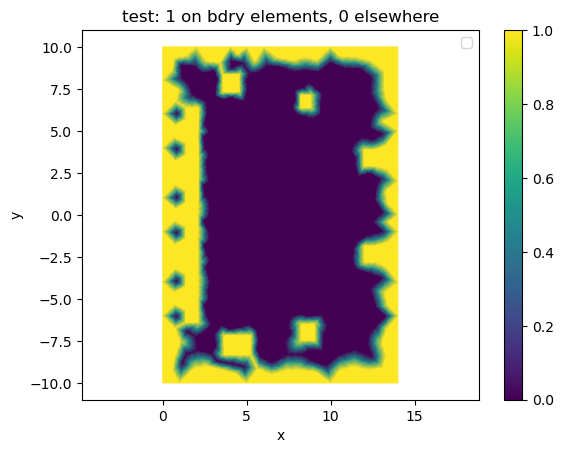

In [58]:
# test -> function which is 0 everywhere and 1 on boundary elements
f = Function(V)
f.dat.data[V_nodes] = 1

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
plt.title(r"test: 1 on bdry elements, 0 elsewhere")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [20]:
from scipy import special
#x,y = SpatialCoordinate(mesh)
mu0 = 4e-7 * pi

V = FunctionSpace(mesh, 'P', 1)
Green = Function(V)
K = Function(V)
V = Function(V)

dof_coords = coord_func.dat.data_ro[:]

# Define G(x,y) with y being a boundary dof:
for idx in dofs:
    X = dof_coords[idx]
    Y = dof_coords[idx]
    Green.dat.data[idx] = G_eval(X[0],X[1],Y[0],Y[1])

In [ ]:
Q = FunctionSpace(m, "DG", 0)

### Define boundary markers to deal with 

In [55]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils.boundary_conditions import JN_coupling_BCs

In [56]:
# Define JN object
V = FunctionSpace(mesh, "P", 1)
bc = JN_coupling_BCs(V,26)

In [5]:
display(bc.neighbors_map[16])
display(bc.neighbors_dist[32])
display(bc.extremes)

array([170,  89], dtype=int32)

array([0.99928571, 0.99928571])

array([31, 15])

In [6]:
n = np.array([0,0],dtype=np.int32)
display(n[1])

0

In [3]:
# Need to map each boundary dof (in 1d mesh) with the idexes of the neighboring facets in the 2D mesh

# Extract the array with all boundary facets:
boundary_facets = mesh.exterior_facets.facets
facet_to_node_map = V.exterior_facet_node_map().values

display(len(boundary_facets))
display(len(facet_to_node_map))

68

68

In [6]:
#display(boundary_facets)
#display(len(mesh.interior_facets.facets))
#display(len(mesh.exterior_facets.facets))
print(f'Total number of facets: ', mesh.num_facets())

print(f'Min index of interior facets: ', np.min(mesh.interior_facets.facets))
print(f'Min index of exterior facets: ', np.min(mesh.exterior_facets.facets))
print(f'Max index of interior facets: ', np.max(mesh.interior_facets.facets))
print(f'Max index of exterior facets: ', np.max(mesh.exterior_facets.facets))

Total number of facets:  4183
Min index of interior facets:  4184
Min index of exterior facets:  4238
Max index of interior facets:  8366
Max index of exterior facets:  6773


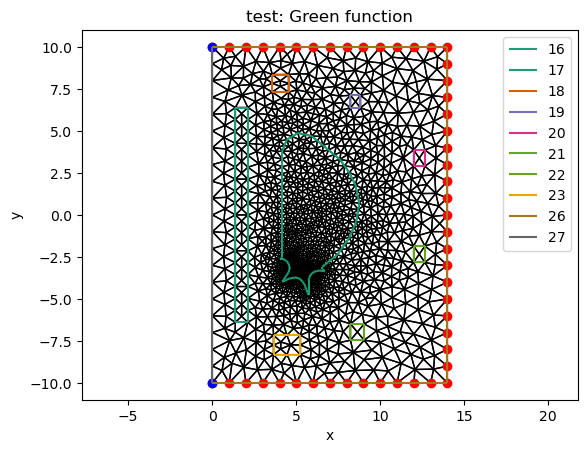

In [7]:
# Plot dofs:

#dofs = facet_to_node_map[0]
dofs = bc.Q_dofs
X = bc.dof_coords[dofs]
Y = bc.dof_coords[dofs[bc.extremes]]

fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(X[:, 0], X[:, 1], color='red')
plt.scatter(Y[:, 0], Y[:, 1], color='blue')
plt.title(r"test: Green function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [234]:
# Find the mapping of each boundary dof to its neighboring facets
n_dofs = len(bc.Q_dofs)
dof_to_facet_map = [[] for _ in range(n_dofs)]
for facet_idx, dofs in enumerate(facet_to_node_map):
    for dof_idx in dofs:
        if dof_idx in bc.Q_dofs:
            i = np.where(bc.Q_dofs == dof_idx)[0][0]
            dof_to_facet_map[i].append(boundary_facets[facet_idx])

In [247]:
# Same but define all tags EXCEPT the neighboring ones
n_dofs = len(bc.Q_dofs)
facet_set = set(list(boundary_facets))
dof_to_facet_map_C = [facet_set.copy() for _ in range(n_dofs)]
for facet_idx, dofs in enumerate(facet_to_node_map):
    for dof_idx in dofs:
        if dof_idx in bc.Q_dofs:
            i = np.where(bc.Q_dofs == dof_idx)[0][0]
            dof_to_facet_map_C[i].discard(boundary_facets[facet_idx])

In [ ]:
# Find for each index the distance with the neighboring ones
for i in range(n_dofs):
    
    np.linalg.norm(dof_coords[i]-dof_coords[j])

### Compute integral over boundary except neighborhood of dof

Ora per calcolare l'integrale su tutto il bordo tranne nell'intorno di un dof, ho due opzioni:
1. Definire per ogni dof una misura di integrazione usando ufl.Measure che escluda dal bordo i due segmenti adiacenti il dof.
    Questa soluzione non funziona perché non capisco che cosa devo passare in "subdomain_data". teoricamente come tipo dovrebbe essere
    un op2.Subset -> ma non si capisce subset di cosa! Guardando vari esempi ho trovato solo roba riferita a FeniCS che usa "DOLFINX", ma 
    sembra non funzionare se applicato a firedrake.
2. Prima di calcolare l'integrale, modificare i mesh tag dei due segmenti vicino al dof. Questa soluzione è costosa perché va fatta ad ogni
    iterazione, ma comunque non capisco come posso accedere direttamente e modificare i tags della mesh.
    Ho provato con il metodo Firedrake "mark_entities" seguendo l'esempio che si trova nella documentazione, nell'esempio in questione si lavorava sui tag degli elementi, provando con i tag delle facets sembra non funzionare.

In [285]:
# Need to define subdomain data:
i = 0
facets_set = mesh.exterior_facets
display(facets_set)
#sd = op2.Subset(facets_set, list(dof_to_facet_map[i]))

In [ ]:
# PROVA CASO 1:
dm = []
max_facet_index = max( np.max(mesh.interior_facets.facets) , np.max(mesh.exterior_facets.facets) )
for i, dof in enumerate(bc.Q_dofs):
    # "markers" è un np array che è 1 nelle posizioni corrisponenti agli indici delle facce su cui voglio integrare,
    # e 0 altrimenti.
    markers = np.zeros(max_facet_index + 1, dtype=np.int32)
    markers[mesh.exterior_facets.facets] = 1
    markers[dof_to_facet_map[i]] = 0
    # Provo a definire la misura dm[i] con Measure, con l'idea di calcolare assemble( f * dm[i] )
    dm.append(Measure("ds", domain=mesh, subdomain_id=15, subdomain_data=markers))

display(type(dm[0]))

ufl.measure.Measure

#### prova metodo 2

In [ ]:
# Mark with 100 the facets of the subset of interest
plex = mesh.topology_dm
for facet_idx in list(dof_to_facet_map_C[0]):
    plex.setLabelValue("boundary_subset", facet_idx, 100)

AttributeError: 'str' object has no attribute '_metadata'

In [ ]:
# Define a measure:
custom_ds = Measure("ds", domain=mesh, subdomain_id=100)

In [281]:
# verify if "100" has become a marker:
_markers = mesh.topology_dm.getLabelIdIS(dmcommon.FACE_SETS_LABEL).indices
display(_markers)

array([15, 16, 17, 18, 19, 20, 21, 22, 23], dtype=int32)

In [299]:
marker = Function(FunctionSpace(mesh, "HDivT", 0))
min_facet_index = min( np.min(mesh.interior_facets.facets) , np.min(mesh.exterior_facets.facets) )
marker.dat.data[facets_idxs] = 1
mesh.mark_entities(marker.topological,100)
mesh1 = RelabeledMesh(mesh, [marker], [100])

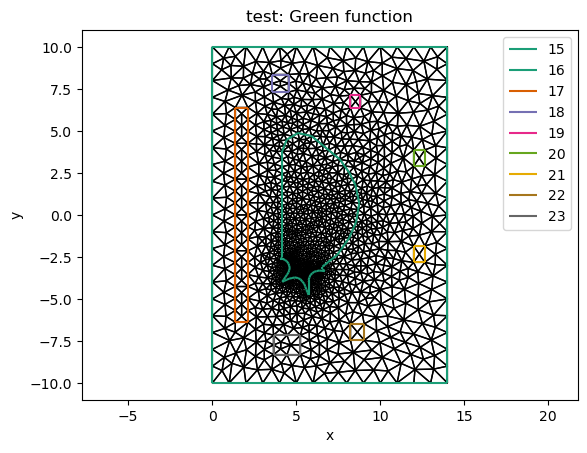

In [ ]:
fig, ax = plt.subplots()
triplot(mesh1, axes=ax)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
#f = Function(V)
i = 0
dof_idx = bc.Q_dofs[i]
crds = dof_coords[dof_idx]

I1 = assemble(f*ds, subdomain_data=facets_set)
print(f"First integral: ", I1)

f.dat.data[dof_idx] = 1
I2 = assemble(f*ds, subdomain_data=facets_set)
print(f"Second integral: ", I2)


First integral:  0.0
Second integral:  0.9992857142856164


In [ ]:
f = Function(V).interpolate(Constant(0.0))

i = 0
dof_idx = bc.Q_dofs[i]

I1 = assemble(f*ds(15))
print(f"First integral: ", I1)

f.dat.data[dof_idx] = 1.0
I2 = assemble(f*ds(15))
print(f"First integral: ", I2)


First integral:  0.0
First integral:  0.9992857142856164


### Try to identify eliminate point source neighborhood by coordinates

In [16]:
from ufl.operators import And, Or

In [17]:
i = 0
dof = bc.Q_dofs[i]
neighbors = bc.neighbors_map[i]
X1 = bc.dof_coords[neighbors[0]]

# rectangular mesh dimension:
Q_dof_coords = bc.dof_coords[bc.Q_dofs]
max_r = max(Q_dof_coords[:, 0])
max_z = max(Q_dof_coords[:, 1])
min_z = min(Q_dof_coords[:, 1])

x,y = SpatialCoordinate(mesh)

if i in bc.extremes:
    if X1[1] == max_z:
        expr = Or((x > X1[0]), (y < max_z))
    else:
        expr = Or( (x > X1[0]) , (y > min_z) )

else:
    X2 = bc.dof_coords[neighbors[1]]

    if X1[1] == X2[1]:
        # source is on x-segments
        r_left = min( X1[0], X2[0] )
        r_right = max( X1[0], X2[0] )

        if X1[1] == max_z:
            # segments are on top boundary
            expr = Or( Or( (x < r_left) , (x > r_right) ) , (y < max_z) ) 
        else:
            # segments are on bottom boundary
            expr = Or( Or( (x < r_left) , (x > r_right) ) , (y > min_z) ) 
    
    elif X1[0] == X2[0]:
        # source is on eastern boundary
        z_bottom = min( X1[1], X2[1] )
        z_top = max( X1[1], X2[1] )
        expr = Or( Or((y < z_bottom) , (y > z_top)) , (x < max_r) )

    else:
        r_left = min(X1[0],X2[0])

        if Or( (X1[1] == max_z) , (X2[1] == max_z) ):
            z_bottom = min(X1[1], X2[1])
            expr = Or( (x < r_left) , (y < z_bottom) )
        else:
            z_top = max(X1[1], X2[1])
            expr = Or( (x < r_left) , (y < z_top) )

In [20]:
sd = SubDomainData(expr)
ds_custom = Measure("ds", domain=mesh, subdomain_id=26, subdomain_data=sd)

Test:

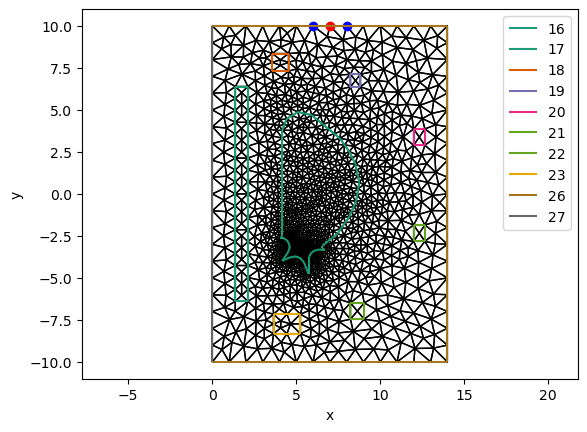

In [26]:
# Plot mesh and dof:
dof_ccord = bc.dof_coords[dof]

fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(dof_ccord[0], dof_ccord[1], color='red')
plt.scatter(X1[0], X1[1], color='blue')
if isinstance(X2, np.ndarray):
    plt.scatter(X2[0], X2[1], color='blue')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


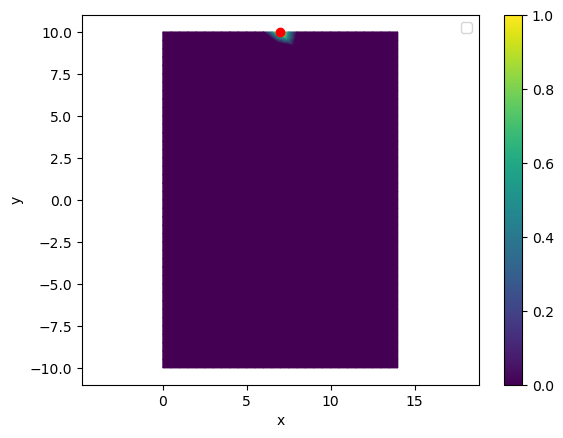

In [28]:
# Define a function which is 0 everywhere but 1 on point source
V = FunctionSpace(mesh, "P", 1)
f = Function(V)
f.dat.data[dof] = 1

fig, ax = plt.subplots()
plt.colorbar(tripcolor(f, axes=ax))
plt.scatter(dof_ccord[0], dof_ccord[1], color='red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [32]:
# Compute integral:
integral = assemble(f * ds_custom)
print(f'Computed integral: ', integral)

NotImplementedError: subdomain_data only supported with cell integrals

Tentativo con maschera:

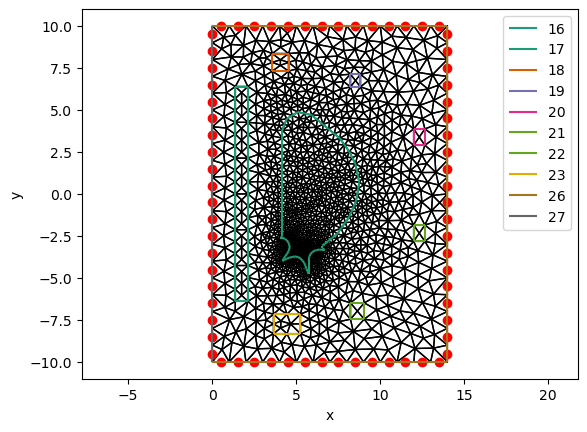

In [ ]:
# Define distance function from the boundary:

boundary_points = DirichletBC(FunctionSpace(mesh, "HDivT", 0),0.0,"on_boundary").nodes
coord_func = Function(VectorFunctionSpace(mesh, "HDivT", 0)).interpolate(as_vector(SpatialCoordinate(mesh)))
coords = coord_func.dat.data_ro[boundary_points]

fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(coords[:,0], coords[:,1], color='red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

/opt/firedrake/firedrake/pyplot/mpl.py:223: UserWarning: No contour levels were found within the data range.
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)


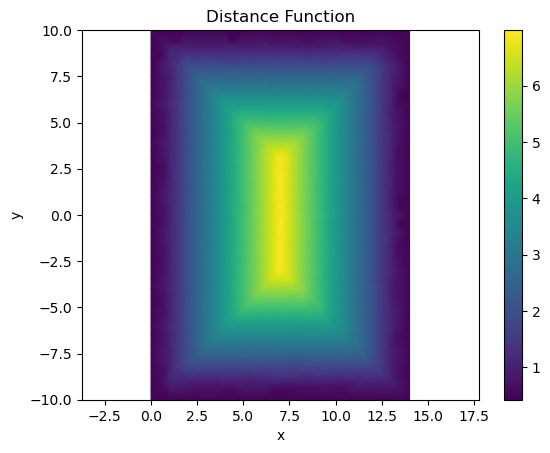

In [ ]:
from scipy.spatial import cKDTree
# === Costruisci KDTree per distanze efficienti
boundary_points = DirichletBC(FunctionSpace(mesh, "HDivT", 0),0.0,"on_boundary").nodes
tree = cKDTree(coords)

# === Calcola distanza con segno per ogni punto
dist = np.zeros(len(bc.dof_coords))
for i, pt in enumerate(bc.dof_coords):
    dist[i], _ = tree.query(pt)

# === Crea funzione finale
d = Function(V)
d.dat.data[:] = dist

fig,ax = plt.subplots()
fig.colorbar(tripcolor(d, axes=ax))
tricontour(d, levels=[0], colors='red', linewidths=2, axes = ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

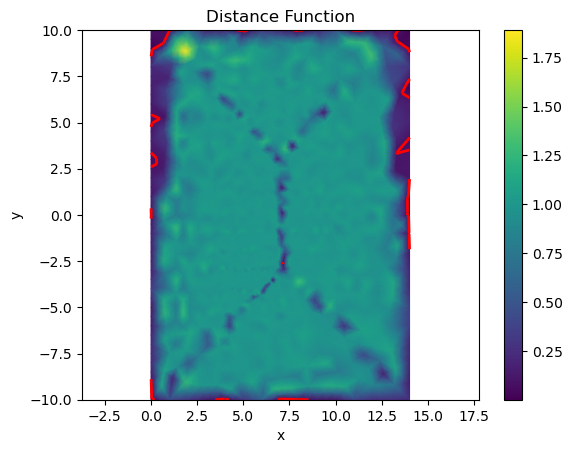

In [67]:
# Provo a plottare gradiente
grad_dist = Function(V).interpolate(dot(grad(d),grad(d)))

fig,ax = plt.subplots()
fig.colorbar(tripcolor(grad_dist, axes=ax))
tricontour(grad_dist, levels=[0.1], colors='red', linewidths=2, axes = ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [68]:
display(type(grad(d)))

ufl.differentiation.Grad

### Manually define a mask on boundary

In [7]:
W = VectorFunctionSpace(mesh, "HDivT", 0)
F = Function(W)

boundary_points = DirichletBC(FunctionSpace(mesh, "HDivT", 0),0.0,"on_boundary").nodes
coord_func = Function(W).interpolate(as_vector(SpatialCoordinate(mesh)))

boundary_coords = coord_func.dat.data_ro[boundary_points]
min_r = min(boundary_coords[:,0])
max_r = max(boundary_coords[:, 0])
max_z = max(boundary_coords[:, 1])
min_z = min(boundary_coords[:, 1])

for idx in boundary_points:
    X = coord_func.dat.data_ro[idx]
    if X[1] == min_z:
        F.dat.data[idx][1] = -1
    if X[1] == max_z:
        F.dat.data[idx][1] = 1
    if X[0] == min_r:
        F.dat.data[idx][0] = -1
    if X[0] == max_r:
        F.dat.data[idx][0] = 1

In [12]:
n = FacetNormal(mesh)
integral = assemble( dot(F,n) * ds )
display(integral)

67.98000000000003

In [ ]:
f = Function(V).interpolate(Constant(0.0))
I1 = assemble(f*dot(F,n)*ds)
display(I1)

0.0

Map each boundary node of the mesh with the two dofs of the H(div) trace space

In [ ]:
n_dofs = len(bc.Q_dofs)
n_segments = len(boundary_points)
neighbor_segments = []

for i in range(n_dofs):
    dof = bc.Q_dofs[i]
    coords = bc.dof_coords[dof]
    dist = np.zeros(n_segments)
    for j in range(n_segments):
        dist[j] = np.linalg.norm(coords-boundary_coords[j])
    neighbor_segments.append(np.argsort(dist)[:2])

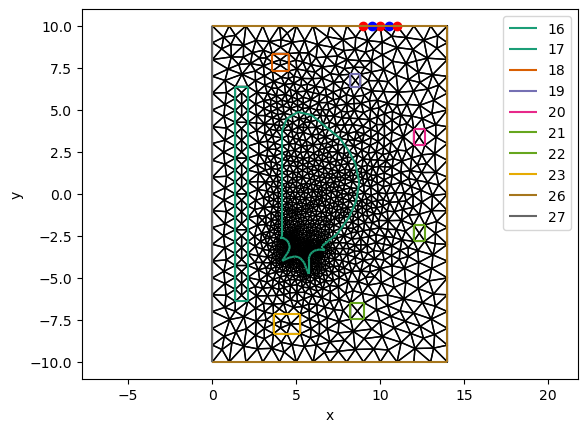

In [51]:
# Visual test:
i = 6
dof = bc.Q_dofs[i]
coords = bc.dof_coords[dof]

ns = neighbor_segments[i]
bound_coords = boundary_coords[ns]

ndof = bc.neighbors_map[i]
neigh_coords = bc.dof_coords[ndof]

fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(coords[0], coords[1], color='red')
plt.scatter(bound_coords[:,0], bound_coords[:,1], color='blue')
plt.scatter(neigh_coords[:,0], neigh_coords[:,1], color='red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [52]:
# Test:
f = Function(V)
I1 = assemble(f*dot(F,n)*ds)
print(f'First Integral: ',I1)   # Should be 0

i = 6   # Pick a boundary dof
dof = bc.Q_dofs[i]

neigh_seg_idx = neighbor_segments[i]
neigh_seg = boundary_points[neigh_seg_idx]
original_F = F.dat.data_ro[neigh_seg]

# Set to 0 F in the segments neighboring the dof:
F.dat.data[neigh_seg] = [[0.0,0.0],[0.0,0.0]]

# Change the value of f in the dof:
f.dat.data[dof] = 10000.0
I2 = assemble(f*dot(F,n)*ds)
print(f'Second Integral: ',I2) # Should still be 0

# Integral modifying another dof should instead be != 0:
f.dat.data[dof] = 0.0
another_dof = bc.Q_dofs[i+1]
f.dat.data[another_dof] = 10000
I3 = assemble(f*dot(F,n)*ds)
print(f'Third Integral: ',I3)

# Restore F value:
F.dat.data[neigh_seg] = original_F

First Integral:  0.0
Second Integral:  0.0
Third Integral:  4996.428571404499


### Test for integrals

In [1]:
from firedrake import *
from firedrake.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils.boundary_conditions import JN_coupling_BCs

In [2]:
mesh = Mesh("../meshes/ITER.msh", dim = 2, distribution_parameters={"partition": False}, reorder = True)
mesh.init()
V = FunctionSpace(mesh, "P", 1)
bc = JN_coupling_BCs(V,26)

In [8]:
# v = 1 everywhere
v = Function(bc.Q).interpolate(Constant(1.0))

# Compute g from v:
g = Function(V)
g.dat.data[bc.Q_dofs] = np.linalg.solve(bc.M, v.dat.data_ro[:])

In [9]:
# Compute v back by integrating g:
n = len(bc.Q_dofs)
mu0 = 4e-7 * pi
x,_ = SpatialCoordinate(mesh)
for i in range(n):
    Green = bc.G_list[i]
    dof_i = bc.Q_dofs[i]
    coords_i = bc.dof_coords[dof_i]
    r_i = coords_i[0]

    # Compute G*g integral far from singularity:
    n = FacetNormal(mesh)
    ns = bc.neighbor_segments[i]
    original_F_values = bc.F.dat.data_ro[ns]
    bc.F.dat.data[ns] = [[0.0,0.0],[0.0,0.0]]
    computed_v = assemble( 1/(mu0 *x) * Green * g * dot(bc.F,n) * ds(26))
    bc.F.dat.data[ns] = original_F_values

    # Compute contribution close to singularity:
    neigh = bc.neighbors_map[i]
    g_neigh = g.dat.data_ro[neigh]
    g_val = g.dat.data_ro[dof_i]
    deltax = bc.neighbors_dist[i]

    for k in range(len(neigh)):
        computed_v += deltax[k] / (4*pi*mu0) * (np.log(8*r_i / deltax[k]) - 1/2) * g_val
        computed_v += deltax[k] / (4*pi*mu0) * (np.log(8*r_i / deltax[k]) - 3/2) * g_neigh[k]

    print(f'Value of v[i] = {v.dat.data_ro[i]}, Computed integral: {computed_v}')

Value of v[i] = 1.0, Computed integral: 1.0000891297009211
Value of v[i] = 1.0, Computed integral: 1.0000824475153731
Value of v[i] = 1.0, Computed integral: 1.0000751749285945
Value of v[i] = 1.0, Computed integral: 1.0000953341365117
Value of v[i] = 1.0, Computed integral: 1.0001011566605165
Value of v[i] = 1.0, Computed integral: 1.0000670651394252
Value of v[i] = 1.0, Computed integral: 1.0001066581596771
Value of v[i] = 1.0, Computed integral: 1.0001118881270736
Value of v[i] = 1.0, Computed integral: 1.0000578740382806
Value of v[i] = 1.0, Computed integral: 1.0001168825813023
Value of v[i] = 1.0, Computed integral: 1.000121672646982
Value of v[i] = 1.0, Computed integral: 1.0001262777790498
Value of v[i] = 1.0, Computed integral: 1.0000465018901301
Value of v[i] = 1.0, Computed integral: 1.0001262762329473
Value of v[i] = 1.0, Computed integral: 1.0000169756442177
Value of v[i] = 1.0, Computed integral: 1.000001679592154
Value of v[i] = 1.0, Computed integral: 1.0001262739237127